# Problem Set 4 
# Support Vector Machines

In this problem set you will implement an SVM and fit it using quadratic programming. We will use the CVXOPT module to solve the optimization problems. 

### Quadratic Programming (QP)

The standard form of a QP can be formulated as 
$$
\begin{align}
\min_x\quad &\frac12 x^TPx + q^Tx\\
\text{subject to }\quad & Gx \preceq h\\
& Ax = b
\end{align}
$$
where $\preceq$ is an element-wise $\leq$.
CVXOPT solver finds an optimal solution $x^*$, given a set of matrices $P, q, G, h, A, b$.

FYI, you can read on the methods to solve quadratic programming problems [here](https://en.wikipedia.org/wiki/Quadratic_programming#Solution_methods).

## Problem 1 (10 points)

Design appropriate matrices to solve the following problem.
$$
\begin{align}
\min_x\quad &f(x)=x_1^2 + 4x_2^2-8x_1-16x_2\\
\text{subject to }\quad & x_1+x_2\leq 5\\
& x_1 \leq 3\\
& x_2 \geq 0
\end{align}
$$

You might need to run this command on the Anaconda terminal: 
#### pip install cvxopt

In [1]:
import numpy as np
from cvxopt import matrix, solvers
# Turns off the printing of CVXOPT solution for the rest of the notebook
solvers.options['show_progress'] = False

P = 2 * matrix([[1., 0.], [0., 4.]])
#------------------------------------------------------------------------------------------
# Define q, G, h
# Hint: the x vector is 2x1
#raise NotImplementedError('Construct the appropriate matrices.')
q = np.array([[-8.],[-16.]])
q = q.astype(np.double)
q = matrix(q)
G = matrix([[1., 1.,0.],[1., 0.,-1.]])
h = np.array([[5],[3.],[0.]])
h = h.astype(np.double)
h = matrix(h)

#------------------------------------------------------------------------------------------

sol = solvers.qp(P, q, G, h)
x1, x2 = sol['x']
print('Optimal x: ({:.8f}, {:.8f})'.format(x1, x2))

Optimal x: (2.99999993, 1.99927914)


Let's visualize the solution

/var/folders/gx/ht8p_08x7bj8zpd0h0f_qlm00000gn/T/ipykernel_4844/40706664.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2, F, cmap='jet')


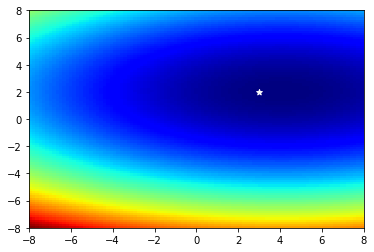

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
F = X1**2 + 4*X2**2 - 8*X1 - 16 * X2

plt.pcolor(X1, X2, F, cmap='jet')
plt.scatter([x1], [x2], marker='*', color='white')
plt.show()

### Linear SVM

Now, let's implement linear SVM. We will do this for a general case, that allows class distributions to overlap.

As a linear model, linear SVM produces classification scores for a given sample $x$ as
$$
 \hat y(x) = w^T\phi(x) + b
$$
where $w\in\mathbb{R}^d$, $b\in\mathbb{R}$ are model weights and bias, respectively, and $\phi$ is a fixed feature-space transformation. Final label prediction is done by taking the sign of $\hat y(x)$.

Given a set of training samples $x_n\in\mathbb{R}^d$, $n\in 1,\ldots, N$, with the corresponding labels $y_i\in\{-1, 1\}$ linear SVM is fit (*i.e.* parameters $w$ and $b$ are chosen) by solving the following constrained optimization task:
$$
\begin{align}
    \min_{w, \xi, b}\quad & \frac12||w||^2 + C\sum_{n=1}^N \xi_n\\
    \text{subject to }\quad & y_n\hat y(x_n) \geq 1 - \xi_n, & n=1,\ldots, N\\
    & \xi_n \geq 0, & n=1,\ldots, N
\end{align}
$$

## Problem 2 (40 points)
## 2.1 [30 pts]
Your task is to implement this using a QP solver by designing appropriate matrices $P$, $q$, $G$, $h$.

##### Hints
1. You need to optimize over $w, \xi, b$. You can simply concatenate them into $\chi = (w, \xi, b)$ to feed it into QP-solver. Now, how to define the objective function and the constraints in terms of $\chi$? (For example, $b_1 + b_2$ can be obtained from vector $(a_1, b_1, b_2, c_1, c_2)$ by taking the inner product with $(0, 1, 1, 0, 0)$).
3. You can use `np.bmat` to construct matrices. Like this:

In [3]:
np.bmat([[np.identity(3), np.zeros((3, 1))],
         [np.zeros((2, 3)), -np.ones((2, 1))]])

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.]])

In [260]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, Y):
        """Fit Linear SVM using training dataset (X, Y).
        
        :param X: data samples of shape (N, d).
        :param Y: data target labels of size (N). Each label is either 1 or -1.
        """
        # Apply transformation (phi) to X
        if self.transform is not None:
            X = self.transform(X)
        d = len(X[0])
        N = len(X)
        
        
        #------------------------------------------------------------------------------------------
        # Construct appropriate matrices here to solve the optimization problem described above.
        # We want optimal solution for vector (w, xi, b). 
        #raise NotImplementedError('Construct the appropriate matrices.')
        
        P = matrix(np.bmat([[np.identity(d), np.zeros((d,N+1))],
                          [np.zeros((N+1,N+d+1))]]))
        q0 = np.bmat([[np.zeros((1,d+1)), self.C*np.ones((1,N))]])
        q = matrix([0.]*(d)+[self.C]*N+[0])
        
        y0 = np.array([Y])
        y1 = np.bmat([[-y0.T]*d])
 
        y2 = np.array(np.multiply(y1,X))
        y3 = np.bmat([y2, -y0.T])

        G = matrix(np.bmat([[y2, -np.identity(N),-y0.T],
                           [np.zeros((N,d)), -np.identity(N), np.zeros((N,1))]]))
        h = matrix([-1.]*N+[0]*N)
        #h = matrix([np.bmat([[np.ones((100,1))],
                           #[np.zeros((100,1))]])])
        
        #------------------------------------------------------------------------------------------
        sol = solvers.qp(P, q, G, h)
        ans = np.array(sol['x']).flatten()
        self.weights_ = ans[:d]
        self.xi_ = ans[d:d+N]
        self.bias_ = ans[-1]
        

        # Find support vectors. A boolean array of length N having True for support
        # vectors and False for the rest.
        margin = Y * (X.dot(model.weights_) + self.bias_)
        self.support_vectors = np.isclose(margin,  1 - self.xi_)
        
    def predict_proba(self, X):
        """
        Make real-valued prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N predicted scores.
        """
        #------------------------------------------------------------------------------------------
        if self.transform is not None:
            X = self.transform(X)
            
        b = self.bias_
        w = self.weights_
        x = self.xi_
        y_hat = np.dot(X,w)+b
        
        #print(y_hat.shape)
        return y_hat
        #raise NotImplementedError('Return y_hat.')
        #------------------------------------------------------------------------------------------

    def predict(self, X):
        """
        Make binary prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N binary predicted labels from {-1, 1}.
        """
        return np.sign(self.predict_proba(X))
    

Let's see how our LinearSVM performs on some data.

In [261]:
from sklearn.datasets import make_classification, make_circles
X = [None, None, None]
y = [None, None, None]
X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
X[1], y[1] = make_circles(n_samples=100, factor=0.5)
X[2], y[2] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=4)

# Go from {0, 1} to {-1, 1}
y = [2 * yy - 1 for yy in y]


/var/folders/gx/ht8p_08x7bj8zpd0h0f_qlm00000gn/T/ipykernel_4844/924786700.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
/var/folders/gx/ht8p_08x7bj8zpd0h0f_qlm00000gn/T/ipykernel_4844/924786700.py:26: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')


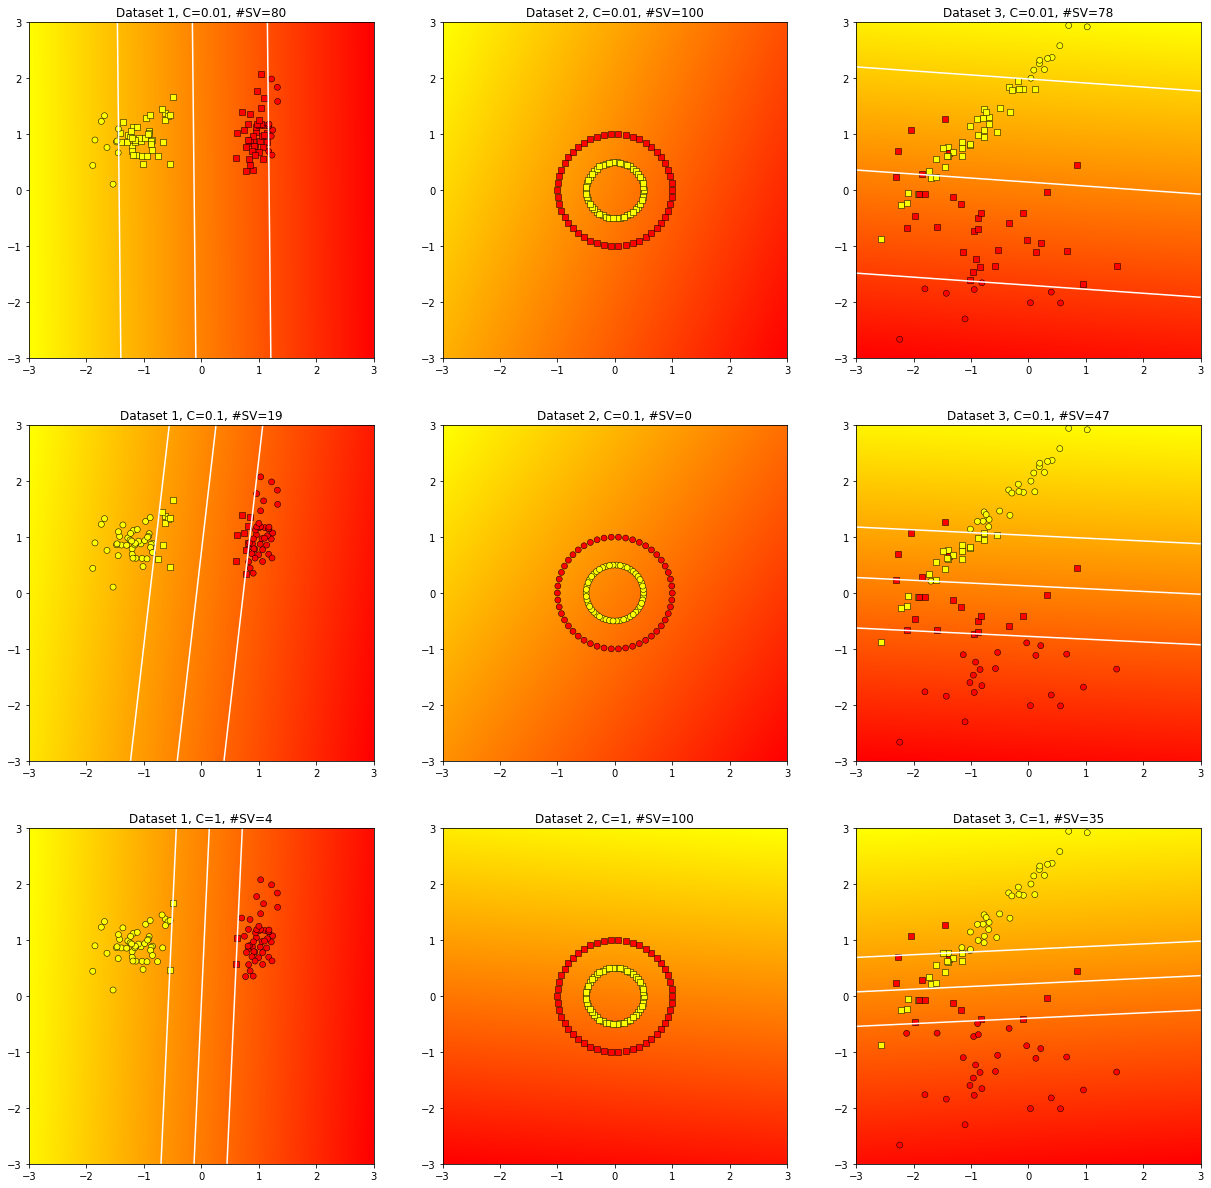

In [262]:
C_values = [0.01, 0.1, 1]

plot_i = 0
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Why does the number of support vectors decrease as $C$ increases?

The number of support vectors decrease as C increases because a larger C means that the margin is more stringent and smaller, resulting in a lower number of support vectors

For debug purposes. Very last model must have almost the same weights and bias:
$$w = \begin{pmatrix}-0.0784521\\ 1.62264867\end{pmatrix}$$
$$b = -0.3528510092782581$$

In [263]:
model.weights_


array([-0.0784521 ,  1.62264867])

In [264]:
model.bias_

-0.3528510092782582

## 2.2 [10 pts]

Even using a linear SVM, we are able to separate data that is linearly inseparable by using feature transformation.

Implement the following feature transformation
$
    \phi(x_1, x_2) = (x_1,\ x_2,\ x_1^2,\ x_2^2,\ x_1x_2)
$

In [253]:
def append_second_order(X):
    """Given array Nx[x1, x2] return Nx[x1, x2, x1^2, x2^2, x1x2]."""
    #------------------------------------------------------------------------------------------
    x1 = X[:,:1]
    x2 = X[:,1:]
    new_X = np.concatenate((X, X*X, x1*x2), axis=1)
    return new_X
    #raise NotImplementedError('Return new_X.')
    #------------------------------------------------------------------------------------------

assert np.all(append_second_order(np.array([[1, 2]])) == np.array([[1, 2, 1, 4, 2]])), 'Transformation is incorrect.'

/var/folders/gx/ht8p_08x7bj8zpd0h0f_qlm00000gn/T/ipykernel_4844/3781809505.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


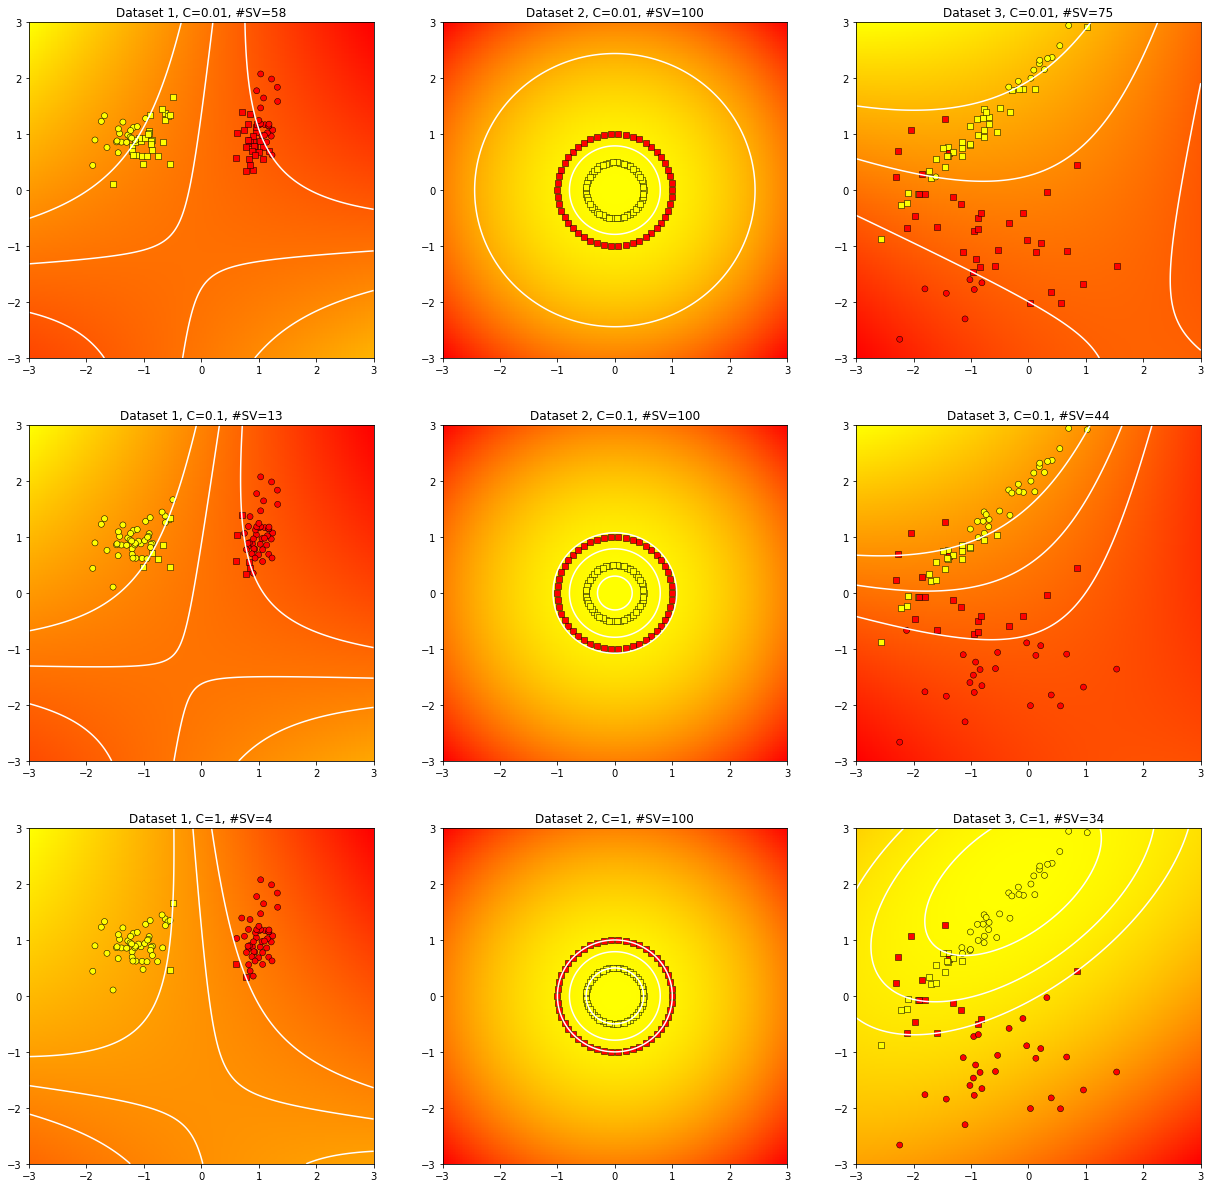

In [254]:
plot_i = 0
C_values = [0.01, 0.1, 1]
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C, transform=append_second_order)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Awesome! Have a look at SVM from scikit-learn module and how it is used. 

# Problem 3 Written Problems (20 points)

## 3.1 PCA [3 pts]
Suppose we are given inputs $𝑥^𝑖 \in ℝ^𝑛, 𝑖=1,…,𝑚$ and we want to learn a lower-dimensional ($k$-dim) PCA projection of the data onto basis vectors $𝑈=[𝑢^1…𝑢^𝑘]$ where each $𝑢^𝑗 \in ℝ^𝑛$.  Write down the equation for the general $k$-dimensional point $z^𝑖$ obtained by projecting an $n$-dimensional point  $𝑥^𝑖$ onto the $k$ basis vectors.

$Z^𝑖=$ ${U^{(k)^T}}$ $*x^i$

## 3.2 CNNs [8 pts]

Draw a convolutional network with input $x \in R^4$, one hidden layer with 3x1 filters and 2 channels with stride 1, and a fully-connected output layer with one neuron. How many parameters does this network have? Include all biases.

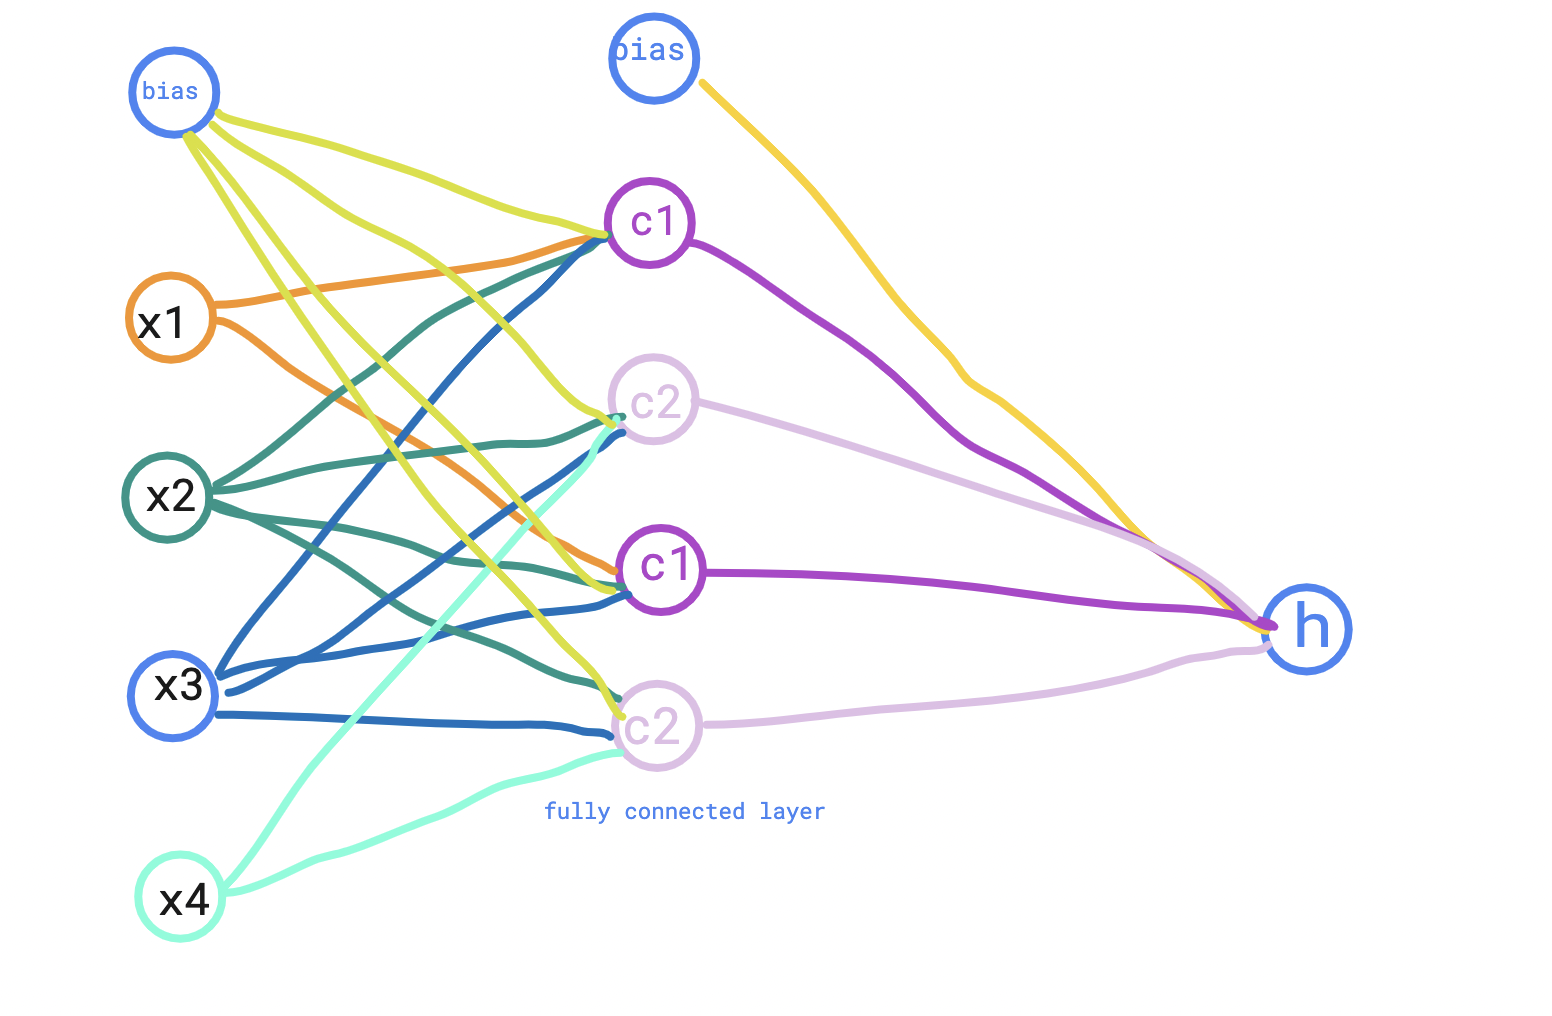

There are 21 parameters

## 3.3 Semi-supervised Learning [3 pts]
What is the difference between co-training and self-training in semi-supervised learning?

The difference between co-training and self-training is that self-training is a wrapper method that can be used with any learner, and cotraining has some assumptions, while self-training does not have any. The assumptions for co-training are that the features can be split into two groups, and each of the sets is good enough to train a model on its own. 

## 3.4 Explainability [3 pts]
What is the difference between black-box and white-box explainability techniques?

White box models are more explainable, and easier to understand what the model is doing to get the results. For black-box models it is more difficult to explain and understand which factors have contributed to the results. Excitation/activation is often used to look at the strongest evidence which contributes to the results, here the parts of an image which contribute the most are highlighted. It is also possible to use excitation dropout to look at the neurons and images which contribute the most to the classifications. 

## 3.5 Domain Adaptation [3 pts]
Assume you have data consisting of images of the road in the summer in which you have labeled road signs, and images of the road in the winter in which you have no labels for the road signs. Explain one way you could label the road signs in the images taken in winter with a decent accuracy.

One way of labeling the winter road signs would be to use domain adaptation with adversarial feature alignment. This way there is an encoder which generates the winter sign features to match the distribution of the summer image features. After that, there is a discriminator which tries to distinguish between the two distributions. After multiple loops, and the discriminator can no longer tell the difference, this means that it is ignoring the irrelevant background (winter/summer) information and only looking at the signs. This way we will be able to accurately label the winter signs as well. 